In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import Packages.ClusteringHelper as ch
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

In [150]:
def ricalcola_lista(lista):
    newlist = []
    for i in reversed(range(1, len(lista))):
        newlist = [lista[i] - lista[i-1]] + newlist
    newlist = [lista[0]] + newlist
    return newlist
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    import re
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
def get_scores(path):
    from os import listdir
    from os.path import isfile, join
    import re
    mypath = path
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f != "settings.txt"]
    onlyfiles.sort(key=natural_keys)
    bcubeds = []
    ceafms = []
    for f in onlyfiles:
        with open(join(mypath , f),
                  encoding='utf-8') as t:
            text = t.read()
            match = re.search('bcubed_f1: (\d+.\d+)', text)
            if match:
                bcubeds.append(float(match.group(1)))
            match = re.search('CEAFm: (\d+.\d+)', text)
            if match:
                ceafms.append(float(match.group(1)))
    return bcubeds, ceafms

In [3]:
text, data = ch.read_aida_yago_conll(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\AIDA-YAGO2-dataset.tsv")
save = False
if save:
    text_file = open('text.txt', 'w')
    text_file.write(text)
    text_file.close()
data

,documents,tokens,indexes,word_indexes,mentions,entities,wikidatas,numeric_codes,alpha_codes
0,0,EU,"(0, 2)",0,,,,,
1,0,rejects,"(3, 10)",1,,,,,
2,0,German,"(11, 17)",2,German,Germany,http://en.wikipedia.org/wiki/Germany,11867,/m/0345h
3,0,call,"(18, 22)",3,,,,,
4,0,to,"(23, 25)",4,,,,,
...,...,...,...,...,...,...,...,...,...
285584,1392,younger,"(1342, 1349)",265,,,,,
285585,1392,brother,"(1350, 1357)",266,,,,,
285586,1392,",","(1358, 1359)",267,,,,,
285587,1392,Bobby,"(1360, 1365)",268,Bobby,Bobby_Charlton,http://en.wikipedia.org/wiki/Bobby_Charlton,4224,/m/01c8x


In [4]:
ents_data = data[data['entities'] != ''].copy()

In [5]:
from pathlib import Path

path_train = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_train_encodings.jsonl")
path_testa = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_testa_encodings.jsonl")
path_testb = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_testb_encodings.jsonl")
raw_encodings_train = open(path_train, 'r').read()
raw_encodings_testa = open(path_testa, 'r').read()
raw_encodings_testb = open(path_testb, 'r').read()

In [6]:
import json

jsonl_parsed_train = [json.loads(x) for x in raw_encodings_train.splitlines()]
jsonl_parsed_testa = [json.loads(x) for x in raw_encodings_testa.splitlines()]
jsonl_parsed_testb = [json.loads(x) for x in raw_encodings_testb.splitlines()]
jsonl_parsed = jsonl_parsed_train + jsonl_parsed_testa + jsonl_parsed_testb
encodings = [x['encoding'] for x in jsonl_parsed]

In [7]:
entities = list(ents_data.entities)

In [8]:
ents_dict = {ent:[] for ent in entities}
for i, ent in enumerate(entities):
    ents_dict[ent].append(encodings[i])

In [9]:
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
max_distances = []
for x in tqdm(ents_dict.values()):
    if len(x) > 1:
        max_distances.append(np.max(cdist(x,x, metric='cosine')))

  0%|          | 0/5598 [00:00<?, ?it/s]

In [10]:
# distanza media massima nei cluster
max_distance_mean=np.mean(max_distances)
max_distance_mean

0.03678974213038678

In [11]:
# distanza mediana massima nei cluster
max_distance_median=np.median(max_distances)
max_distance_median

0.029085082846423638

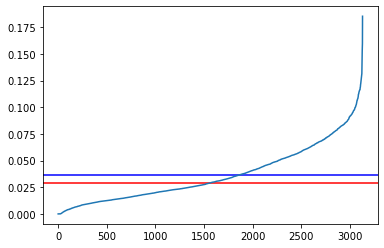

In [12]:
# distribuzione delle distanze massime nei cluster
max_distances.sort()
plt.axhline(y=max_distance_median, color='r', linestyle='-')
plt.axhline(y=max_distance_mean, color='b', linestyle='-')
plt.plot(max_distances)

In [13]:
# varianza dei cluster
var_distances = []
for x in tqdm(ents_dict.values()):
    if len(x) > 1:
        matrix = cdist(x,x, metric='cosine')
        matrix = matrix[~np.eye(matrix.shape[0],dtype=bool)].reshape(matrix.shape[0],-1)

        var_distances.append(np.var(matrix))

  0%|          | 0/5598 [00:00<?, ?it/s]

In [14]:
# media della varianza
np.mean(sorted(var_distances))

0.000135063425200384

In [15]:
# varianza massima
np.max(sorted(var_distances))

0.00261428652061785

In [16]:
#distrubuzione lunghezza cluster
from collections import Counter
from matplotlib.pyplot import figure
lists = sorted(dict(Counter([len(x) for x in ents_dict.values()])).items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
x = [str(el) for el in x]
figure(figsize=(25,5), dpi=1200)
plt.xlabel("Lunghezza del cluster")
plt.ylabel("# elementi")
plt.bar(x, y)
# plt.savefig('./prova2.png')

<BarContainer object of 100 artists>

In [17]:
x = [int(el) for el in x]
np.max(x)

636

In [18]:
# media lunghezza cluster > di 2 elementi
np.mean([len(x) for x in ents_dict.values()])

4.969096105752055

In [19]:
# mediana lunghezza cluster > di 2 elementi
np.median([len(x) for x in ents_dict.values()])

2.0

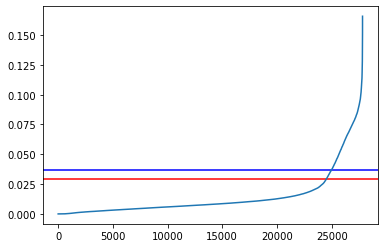

In [20]:
# algoritmo knn con numero di vicini il la lunghezza media di un cluster

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine')
neighbors_fit = neighbors.fit(encodings)
distances, indices = neighbors_fit.kneighbors(encodings)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=max_distance_median, color='r', linestyle='-')
plt.axhline(y=max_distance_mean, color='b', linestyle='-')
plt.plot(distances)

## Tempo di calcolo

In [96]:
step10 = [0, 0.42981094506103545, 1.0415741640608758, 2.4943188320612535, 4.044922505039722, 5.285246517043561, 6.781469293986447, 9.42170415003784, 12.226022941991687, 15.590955269988626, 18.949513160041533, 23.455095808021724, 29.598521925043315, 34.8841205870267, 43.57144063501619, 50.20517915103119, 58.15541011898313, 66.27019275305793, 75.2410443869885, 84.02399934106506, 93.23616406903602, 103.92453118297271, 114.39332942699548, 126.73030633700546, 140.82596722303424, 154.06339673604816, 167.43714733899105, 181.0629540779628, 195.33516110200435, 211.80984024505597, 228.5083669789601, 245.2457881900482, 267.2299878699705, 286.68541528703645, 308.09537829703186, 330.26461983600166, 354.6332727660192, 378.55410529102664, 404.25622338301037, 429.665300647961, 455.2390138399787, 482.7545969559578, 510.992013597046, 539.4473323379643, 571.7662718530046, 602.7301457480062, 634.2221070850501, 667.612803786993, 700.2416068649618, 735.5191083080135, 770.9208011410665, 808.8282980100485, 846.4881262070267, 887.8368406119989, 925.6192076939624, 964.0728903380223, 1003.2796134040691, 1044.3865630300716, 1086.6148979850113, 1131.0439860749757, 1174.1252835979685, 1220.2910422029672, 1266.5129999599885, 1312.715056488989, 1362.1304189370712, 1411.791809819988, 1460.7720484670717, 1516.9355690609664, 1570.2192334190477, 1625.7751329600578, 1679.967886922066, 1736.5681883100187, 1795.4438500499818, 1851.4897914549801, 1910.9374962430447, 1969.9070525610587, 2029.802076222957, 2092.759056987008, 2154.965188215021, 2215.4812420209637, 2280.2006240939954, 2343.423590501072, 2408.6564976610243, 2475.78315671999, 2544.422472706996, 2615.281363748014, 2688.3041346480604, 2761.323743075016, 2833.439787117066, 2908.4791551380185, 2981.8624312350294, 3058.039860900957, 3139.506242895033, 3216.628738928004, 3296.8510794700123, 3379.3135114279576, 3465.3278129110113, 3549.042915099999, 3635.317095370963, 3720.239191335044, 3805.395108969067, 3890.237525311066, 3980.728958394029, 4068.0570950440597, 4159.6108835829655, 4250.352248645038, 4344.823270024965, 4438.299033893039, 4530.0154708659975, 4623.413152504014, 4719.723689205013, 4814.077426575008, 4907.866712874966, 5005.583455690998, 5106.577762742061, 5205.307356368052, 5305.119502059068, 5404.187880677055, 5512.53093909903, 5617.886117334012, 5726.358785231016, 5833.4537738260115, 5954.182139564073, 6062.007592977025, 6171.224302830058, 6287.012766849017, 6405.6142548030475, 6519.405990445055, 6633.662692629034, 6752.397891298053, 6876.465541027021, 6997.213325178018, 7120.7783493619645, 7246.762885504984, 7379.21172817098, 7504.422195352963, 7631.72859568405, 7759.604146861006, 7895.8578612320125, 8026.363547570072]
step30 = [0, 5.403613602975383, 10.114973576972261, 18.381123579922132, 27.774077829904854, 39.45828718296252, 52.24061701295432, 64.96367700700648, 80.06850790500175, 94.82467992301099, 113.35582808800973, 138.84396912099328, 167.75760228792205, 194.7466277849162, 225.71682065492496, 259.54477809590753, 293.6065786969848, 329.32984751893673, 370.93804497097153, 414.38619501597714, 462.8214301589178, 512.1068935429212, 564.6702201029984, 628.0415376249002, 687.4728092739824, 746.911992906942, 810.1009996680077, 874.1334203049773, 947.4075430319645, 1023.6206008669687, 1107.5621940239798, 1186.646093184012, 1283.8683555260068, 1373.9176372109214, 1465.0906033359934, 1567.9219543829095, 1663.8534856279148, 1759.0362416309072, 1858.8813729779795, 1961.7107397599611, 2076.070221366943, 2200.4125416479073, 2315.7168831309536, 2436.0870227249106, 2560.0776011570124, 2688.137754442985, 2818.6483924749773, 2947.3254055919824]
step70 = [0, 26.350578829064034, 64.10624895000365, 88.6633695870405, 115.78390256105922, 161.4956322479993, 209.62476526002865, 257.33104761398863, 311.30084750207607, 380.2871498480672, 462.3279766170308, 535.6835980070755, 618.5958751430735, 718.6381114220712, 820.9591910860036, 927.7311275739921, 1032.5424526049756, 1158.393399124965, 1298.6360149329994, 1440.7800448610215, 1577.7607569319662]
step120 = [0, 78.62441634794232, 148.31120093294885, 233.9035187260015, 318.4231387799373, 417.4119757430162, 552.3018769399496, 663.8229932719842, 826.4469397820067, 973.6386114830384, 1133.2949025499402, 1307.5902004200034, 1455.6658146789996]

Text(0, 0.5, '# documents')

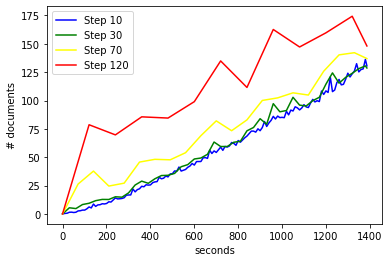

In [102]:
fig, ax = plt.subplots()
ax.plot([0] + list(range(11, 1388, 10)) + [1388], ricalcola_lista(step10), label='Step 10', color='blue')
ax.plot([0] + list(range(31, 1388, 30)) + [1388], ricalcola_lista(step30), label='Step 30', color='green')
ax.plot([0] + list(range(71, 1388, 70)) + [1388], ricalcola_lista(step70), label='Step 70', color='yellow')
ax.plot([0] + list(range(121, 1388, 120)) + [1388], ricalcola_lista(step120), label='Step 120', color='red')
ax.legend(loc='upper left')
plt.xlabel('seconds')
plt.ylabel('# documents')

plot of scores in times

In [153]:
b3_120 ,ceaf_120 = get_scores("D:/Sgmon/Documents/Magistrale/TESI/Results_mixed/TimeEvolving/step_120/")
b3_70 ,ceaf_70 = get_scores("D:/Sgmon/Documents/Magistrale/TESI/Results_mixed/TimeEvolving/step_70/")
b3_30 ,ceaf_30 = get_scores("D:/Sgmon/Documents/Magistrale/TESI/Results_mixed/TimeEvolving/step_30/")
b3_10 ,ceaf_10 = get_scores("D:/Sgmon/Documents/Magistrale/TESI/Results_mixed/Best/")

Text(0, 0.5, '# documents')

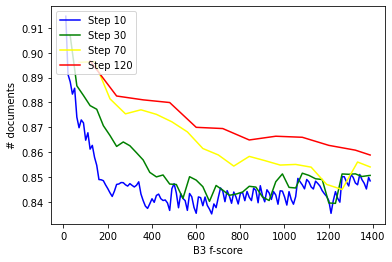

In [158]:
fig, ax = plt.subplots()
ax.plot(list(range(11, 1388, 10)) + [1388], b3_10, label='Step 10', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], b3_30, label='Step 30', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], b3_70, label='Step 70', color='yellow')
ax.plot(list(range(121, 1388, 120)) + [1388], b3_120, label='Step 120', color='red')
ax.legend(loc='upper left')
plt.xlabel('B3 f-score')
plt.ylabel('# documents')

Text(0, 0.5, '# documents')

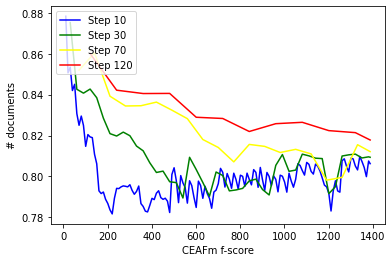

In [159]:
fig, ax = plt.subplots()
ax.plot(list(range(11, 1388, 10)) + [1388], ceaf_10, label='Step 10', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], ceaf_30, label='Step 30', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], ceaf_70, label='Step 70', color='yellow')
ax.plot(list(range(121, 1388, 120)) + [1388], ceaf_120, label='Step 120', color='red')
ax.legend(loc='upper left')
plt.xlabel('CEAFm f-score')
plt.ylabel('# documents')
